In [5]:
import json
import requests
import os
import re

import pandas as pd
import tensorflow_hub as hub
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

# Structured Data

In [25]:
vendor1_df = pd.read_csv("./data/vendor1-data.csv")
vendor2_df = pd.read_csv("./data/vendor2-data.csv")

In [26]:
vendor1_df.shape, vendor2_df.shape

((100000, 6), (100000, 7))

In [27]:
vendor1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ProviderName  99747 non-null   object
 1   Specialty     99609 non-null   object
 2   City          100000 non-null  object
 3   Start Hour    100000 non-null  int64 
 4   End Hour      100000 non-null  int64 
 5   Cost          100000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 4.6+ MB


In [28]:
vendor2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Fname   99670 non-null   object
 1   Lname   99747 non-null   object
 2   spec    99578 non-null   object
 3   city    100000 non-null  object
 4   s_hour  100000 non-null  int64 
 5   e_hour  100000 non-null  int64 
 6   cost    100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


`ProviderName` in vendor 1 should be seperated into first name and last name columns.

array([[<Axes: title={'center': 'Start Hour'}>,
        <Axes: title={'center': 'End Hour'}>],
       [<Axes: title={'center': 'Cost'}>, <Axes: >]], dtype=object)

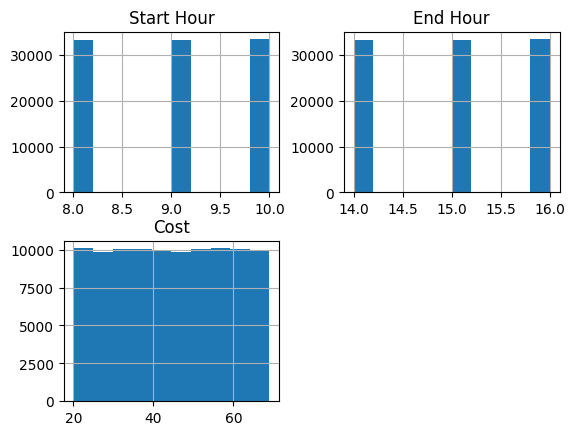

In [29]:
vendor1_df.hist()

array([[<Axes: title={'center': 's_hour'}>,
        <Axes: title={'center': 'e_hour'}>],
       [<Axes: title={'center': 'cost'}>, <Axes: >]], dtype=object)

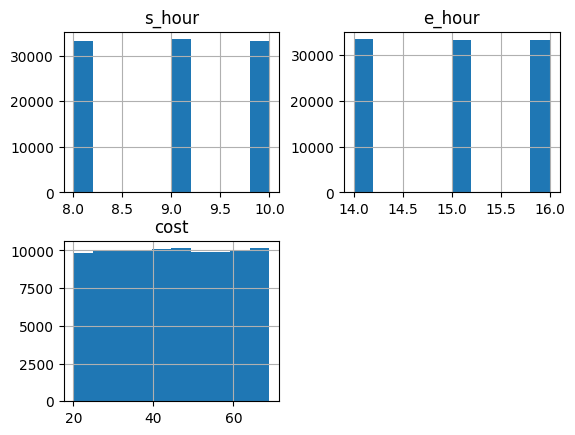

In [30]:
vendor2_df.hist()

City, start hour, end hour, and cost columns have no missing values and their values are normal.

For specialities, I'll normalize them using semantic similarity:

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(module_url)

In [ ]:
specialities = pd.concat([vendor1_df["Specialty"], vendor2_df["spec"]]).unique()
specialities = specialities[~pd.isnull(specialities)]
specialities_embeddings = embed(specialities)

In [ ]:
expected_specialities_number = 135
specialities_kmeans_fit = KMeans(expected_specialities_number, random_state=0).fit(
    specialities_embeddings
)

In [ ]:
specialities_normalizer = []

for i in range(expected_specialities_number):
    cluster_specialities = specialities[specialities_kmeans_fit.labels_ == i]
    cluster_specialities_embeddings = specialities_embeddings[
        specialities_kmeans_fit.labels_ == i
    ]
    cluster_center = specialities_kmeans_fit.cluster_centers_[i]
    distances = cosine_similarity(cluster_specialities_embeddings, [cluster_center])
    closest_speciality_index = distances.argmin()
    closest_speciality = cluster_specialities[closest_speciality_index]

    specialities_normalizer.append(
        {
            "speciality": closest_speciality,
            "specialities_cluster": cluster_specialities.tolist(),
        }
    )

In [ ]:
with open("./data/specialities_normalizer.json", "w") as file:
    json.dump(specialities_normalizer, file)

For the cities, I will use an API to map each unique address into a regoin.

In [ ]:
cities = pd.concat([vendor1_df["City"], vendor2_df["city"]]).unique()
cities_regoins = {}
start_city_index = 0

while start_city_index < len(cities):
    # security break
    break

    try:
        for idx, city in enumerate(cities[start_city_index:]):
            api_key = "bb11569cd4a4060a3aab3ea29002db60"
            city = city.replace("\\N", ",")
            api = f"http://api.positionstack.com/v1/forward?access_key={api_key}&query={city}"
            response = requests.get(api)
            body = response.json()

            if len(body["data"]) > 0:
                cities_regoins[city] = body["data"][0]["region"]

        break
    except Exception as e:
        start_city_index += idx
        print(e, city)

  # Free Text

In [31]:
def build_dataset():
    base_dir = "./data/free-text/"
    reports_files = os.listdir(base_dir)

    reports_files.remove("indexes")
    reports_files.sort(key=lambda x: int(x.split(".")[0]))

    reports_records = []

    for report_file in reports_files:
        with open(base_dir + report_file, "r") as file:
            report = file.read()
            free_text_records = report.splitlines()

            with open(
                f"{base_dir}indexes/{report_file.split('.')[0]}_Indexes.txt"
            ) as indexes_file:

                def transform_matches(matches):
                    return ((int(matches[0]), int(matches[1]) - 1), matches[2])

                labels = list(
                    map(
                        lambda line: transform_matches(
                            re.findall(r"^(\d+)-(\d+): (.+)$", line)[0]
                        ),
                        indexes_file.read().splitlines(),
                    )
                )

                for record_idx, free_text_record in enumerate(free_text_records):
                    record_start_index = (
                        len("".join(free_text_records[:record_idx])) + record_idx
                    )
                    record_end_index = record_start_index + len(free_text_record) - 1

                    record_tokens = word_tokenize(free_text_record, preserve_line=True)
                    for token_index, token in enumerate(record_tokens):
                        if re.match(r"^\d+-\d+$", token):
                            record_tokens = (
                                record_tokens[:token_index]
                                + list(re.findall(r"(\d+)(-)(\d+)", token)[0])
                                + record_tokens[token_index + 1 :]
                            )

                    record_lexemes = []

                    for token_index, token in enumerate(record_tokens):
                        start_index = free_text_record.index(
                            token,
                            record_lexemes[token_index - 1]["end_index"] + 1
                            if token_index > 0
                            else 0,
                        )
                        end_index = start_index + len(token) - 1

                        lexeme = {
                            "token": token,
                            "start_index": start_index,
                            "end_index": end_index,
                        }

                        record_lexemes.append(lexeme)

                    relevant_labels = list(
                        set(
                            filter(
                                lambda label: label[0][0] >= record_start_index
                                and label[0][1] <= record_end_index,
                                labels,
                            )
                        )
                    )

                    def get_lexeme_label(lexeme):
                        label = next(
                            filter(
                                lambda label: (
                                    lexeme["start_index"] + record_start_index
                                )
                                >= label[0][0]
                                and (lexeme["end_index"] + record_start_index)
                                <= label[0][1],
                                relevant_labels,
                            ),
                            None,
                        )

                        return label[1] if label else "Other"

                    record_lexemes = [
                        {
                            "token": lexeme["token"],
                            "label": get_lexeme_label(lexeme),
                        }
                        for lexeme in record_lexemes
                    ]

                    reports_records.append(record_lexemes)

    return reports_records

In [32]:
reports_records = build_dataset()

In [34]:
reports_records = [
    [
        list(map(lambda lexeme: lexeme["token"], report_records_lexemes)),
        list(map(lambda lexeme: lexeme["label"], report_records_lexemes)),
    ]
    for report_records_lexemes in reports_records
]
reports_df = pd.DataFrame(reports_records, columns=["tokens", "labels"])

In [35]:
reports_df.iloc[1].values

array([list(['MelissaDodrill', 'and', 'he', 'has', 'fees', 'of', '67', '$', 'he', 'is', 'special', 'in', 'Family', 'Practice', '/', 'General', 'Practice', 'his', 'working', 'hours', 'are', ':', '9', '-', '14', ',', 'he', 'do', 'his', 'job', 'in', 'SHINNSTON']),
       list(['ProviderName', 'Other', 'Other', 'Other', 'Other', 'Other', 'Cost', 'Other', 'Other', 'Other', 'Other', 'Other', 'Speciality', 'Speciality', 'Speciality', 'Speciality', 'Speciality', 'Other', 'Other', 'Other', 'Other', 'Other', 'StartHour', 'Other', 'EndHour', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'City'])],
      dtype=object)

In [36]:
reports_df.to_csv("./data/reports.csv", index=False)

Model training at [Colab notebook](https://colab.research.google.com/drive/1AMXReDrEqv3jWYU7fvhPabtEmBgm1gc3#scrollTo=tg7hfzS3Kg8G).

In [2]:
freetext_model = pipeline("ner", model="./models/freetext")

All model checkpoint layers were used when initializing TFDistilBertForTokenClassification.

All the layers of TFDistilBertForTokenClassification were initialized from the model checkpoint at ./models/freetext.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForTokenClassification for predictions without further training.


In [12]:
text = "TammieNelson and he has fees of 29 $ he is special in Primary Care Physicians Internal Medicine his working hours are: 10-15, he do his job in WICHITA"
freetext_model(text)

[{'entity': 'ProviderName',
  'score': 0.9999745,
  'index': 1,
  'word': 'shan',
  'start': 0,
  'end': 4},
 {'entity': 'ProviderName',
  'score': 0.99996805,
  'index': 2,
  'word': '##na',
  'start': 4,
  'end': 6},
 {'entity': 'ProviderName',
  'score': 0.9999733,
  'index': 3,
  'word': 'keel',
  'start': 25,
  'end': 29},
 {'entity': 'ProviderName',
  'score': 0.9999478,
  'index': 4,
  'word': '##e',
  'start': 29,
  'end': 30},
 {'entity': 'Other',
  'score': 0.9999604,
  'index': 5,
  'word': 'works',
  'start': 61,
  'end': 66},
 {'entity': 'Other',
  'score': 0.99996054,
  'index': 6,
  'word': 'in',
  'start': 67,
  'end': 69},
 {'entity': 'City',
  'score': 0.99986506,
  'index': 7,
  'word': 'fort',
  'start': 70,
  'end': 74},
 {'entity': 'City',
  'score': 0.9998534,
  'index': 8,
  'word': 'collins',
  'start': 75,
  'end': 82},
 {'entity': 'City',
  'score': 0.999866,
  'index': 9,
  'word': '\\',
  'start': 82,
  'end': 83},
 {'entity': 'City',
  'score': 0.99987435,